# Import / Prepare Data

In [1]:
# Import packages

import pandas as pd
import string
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
# Import scraped data

df_anx = pd.read_csv('anxiety.csv')
df_dep = pd.read_csv('depression.csv')

In [3]:
# Drop rows with null selftext

df_anx.drop(df_anx[df_anx['selftext'].isnull() == True].index, inplace=True)
df_dep.drop(df_dep[df_dep['selftext'].isnull() == True].index, inplace=True)

In [4]:
# Drop rows without selftext

df_anx.drop(df_anx[df_anx['selftext'] == '[removed]'].index, inplace=True)
df_dep.drop(df_dep[df_dep['selftext'] == '[removed]'].index, inplace=True)

In [52]:
df_anx.shape, df_dep.shape

((2754, 5), (2351, 5))

In [5]:
# Depression, Anxiety : (0, 1)

df_dep['result'] = 0
df_anx['result'] = 1

df_full = pd.concat([df_anx, df_dep], axis=0, join='outer')

In [6]:
# Create list of punctuations to remove
# Create list of stopwords using NLTK

punc_str = string.punctuation + "’"
stopword = nltk.corpus.stopwords.words('english')

In [7]:
# Create stemming/lemmatizing objects

ps = nltk.PorterStemmer()
wnl = nltk.WordNetLemmatizer()

In [8]:
# Stemming (not in use)

def clean_data_stem(text):
    # remove punctuation
    text = str(text)
    text_nopunc = ''.join(char.lower() for char in text if char not in punc_str)
    
    # tokenize
    tokenized = re.split('\W+', text_nopunc)
    
    # remove words with numbers
    text_remove_num = [re.sub(r"^\d+|\d$","",word) for word in tokenized]
    
    # stem + remove stopwords
    text_clean = [ps.stem(word) for word in text_removed_num if word not in stopword]
    
    return text_clean

In [9]:
# Lemmatize

def clean_data_lemm(text):
    # remove punctuation
    text = str(text)
    text_nopunc = ''.join(char.lower() for char in text if char not in punc_str)
    
    # tokenize
    tokenized = re.split('\W+', text_nopunc)
    
    # remove words with numbers
    text_remove_num = [re.sub(r"^\d+|\d$","",word) for word in tokenized]
    
    # lemmatize + remove stopwords
    text_clean = [wnl.lemmatize(word) for word in text_remove_num if word not in stopword]
    
    return text_clean

# Vectorization
1. N-Gram (1,2)
2. TF-IDF

## N-Gram (n = 1,2)

In [10]:
# Create N-Gram object

ngram_vec = CountVectorizer(ngram_range=(1,2), max_features=10000)

In [11]:
# Clean data with string output

def clean_ngram(text):
    # remove punctuation
    text = str(text)
    text_nopunc = ''.join(char.lower() for char in text if char not in punc_str)
    
    # tokenize
    tokenized = re.split('\W+', text_nopunc)
    
    # remove words with numbers
    text_remove_num = [re.sub(r"^\d+|\d$","",word) for word in tokenized]
    
    # lemmatize + create string
    text_clean = ' '.join([wnl.lemmatize(word) for word in text_remove_num if word not in stopword])
    
    return text_clean

In [12]:
# Clean selftext column for n-gram vectorization

df_full['selftext_ngram'] = df_full['selftext'].apply(lambda x: clean_ngram(x))

In [13]:
# Create n-gram vector

X_ngram_ = ngram_vec.fit_transform(df_full['selftext_ngram'])

In [14]:
# Create n-gram dataframe

X_ngram = pd.DataFrame(X_ngram_.toarray())

## TF-IDF

In [15]:
# Create TF-IDF object

tfidf_vec = TfidfVectorizer(analyzer=clean_data_lemm, max_features=10000)

In [16]:
# Create TF-IDF vector

X_tfidf_ = tfidf_vec.fit_transform(df_full['selftext'])

In [17]:
# Create TF-IDF df

X_tfidf = pd.DataFrame(X_tfidf_.toarray())

# Classification Models
1. Bernoulli Naive Bayes (N-Gram, TF-IDF)
2. Multinomial Naive Bayes (N-Gram, TF-IDF)
3. Logistic Regression (N-Gram, TF-IDF)

In [18]:
import sklearn
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay, plot_roc_curve

## Functions

In [19]:
# Return train/test scores and classification table

def train_test_classification(y_pred, clf, X_train, X_test, y_train, y_test):
    y_pred = clf.predict(X_test)
    print(f"Train Score: {clf.score(X_train, y_train)}")
    print(f"Test Score: {clf.score(X_test, y_test)}")
    print('\n')
    print('Classification Report')
    print(classification_report(y_test, y_pred))

In [59]:
# Return confusion matrix

def confusion_matrix_(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    plt.figure(figsize=(15,8), dpi=500)
    disp.plot()
    plt.title('Confusion Matrix',fontsize=16,fontweight='bold')

    plt.savefig('confusion.png', transparent=True)
    plt.show()

In [60]:
# Return feature importance for Naive Bayes

def feature_importance_NB_display(clf, data, vectorizer):
    """
    FOR NAIVE BAYES MODELS ONLY!!
    returns feature importance to class 1 relative to class 0
    positive -> anxiety, negative -> depression
    feature_log_prob_ represents probability of token occurences in each observation
    taking difference accounts for tokens that appear in both classes
    scale by the count of words (data) to identify feature importance
    """
    # data : Vectorized dataframe
    # clf : Fitted NB classifier
    counts = data.sum()
    delta_log_prob = clf.feature_log_prob_[1,:] - clf.feature_log_prob_[0,:]

    """
    Plot bar chart of feature importance
    """
    feature_impt = np.multiply(counts, delta_log_prob)
    scores = pd.DataFrame({'tokens' : pd.Series(vectorizer.get_feature_names_out()), 'score' : feature_impt})
    top_anx = scores.sort_values('score', ascending=False).rename(columns={'score' : 'anxiety score'}).head(10)
    top_dep = scores.sort_values('score', ascending=True).rename(columns={'score' : 'depression score'}).head(10)
    top_dep['depression score'] = top_dep['depression score'].abs() 
    
    fig, ax = plt.subplots(1,2, figsize=(15,8), dpi=500)

    fig.suptitle('Feature Importance', fontsize=16)

    ax[0].barh(top_anx['tokens'], top_anx['anxiety score'])
    ax[0].set_title('Top 10 Feature Importance for Anxiety')
    ax[0].set_xlabel('Score')

    ax[1].barh(top_dep['tokens'], top_dep['depression score'])
    ax[1].set_title('Top 10 Feature Importance for Depression')
    ax[1].set_xlabel('Score')

    plt.show()

In [61]:
# Return feature importance for Logistic Regression

def feature_importance_logistic(vectorizer, clf):
    dict_tfidf = vectorizer.vocabulary_
    
    """
    Create feature importance dataframe
    """
    sorted_coef = []
    for token, index in dict_tfidf.items():
        token_ = token
        score_ = clf.coef_[0][index]
        sorted_coef.append([token_, score_])
    
    log_reg_scores = pd.DataFrame(sorted_coef, columns=['tokens', 'score'])
    top_anx_log = log_reg_scores.sort_values('score', ascending=False).head(10)
    top_dep_log = log_reg_scores.sort_values('score', ascending=True).head(10)
    top_dep_log['score'] = top_dep_log['score'].abs() 
    
    """
    Plot bar chart of feature importance
    """
    fig, ax = plt.subplots(1,2, figsize=(15,8), dpi=500)

    fig.suptitle('Feature Importance', fontsize=16)

    ax[0].barh(top_anx_log['tokens'], top_anx_log['score'])
    ax[0].set_title('Top 10 Feature Importance for Anxiety')
    ax[0].set_xlabel('Score')

    ax[1].barh(top_dep_log['tokens'], top_dep_log['score'])
    ax[1].set_title('Top 10 Feature Importance for Depression')
    ax[1].set_xlabel('Score')
    
    plt.savefig('feature.png', transparent=True)
    plt.show()

In [23]:
# Create y vector

y = df_full['result']

## N-Gram Vectorization

In [24]:
# N-Gram train test split

X_train_ngram, X_test_ngram, y_train_ngram, y_test_ngram = train_test_split(
    X_ngram, y, train_size=0.8, random_state=1)

### Bernoulli Naive Bayes

In [25]:
BernNB = BernoulliNB()
ngram_bern = BernNB.fit(X_train_ngram, y_train_ngram)
y_pred_ngram_bern = ngram_bern.predict(X_test_ngram)
train_test_classification(y_pred_ngram_bern, ngram_bern, X_train_ngram, X_test_ngram, y_train_ngram, y_test_ngram)

Train Score: 0.8454946131243879
Test Score: 0.7992164544564153


Classification Report
              precision    recall  f1-score   support

           0       0.80      0.71      0.75       436
           1       0.80      0.87      0.83       585

    accuracy                           0.80      1021
   macro avg       0.80      0.79      0.79      1021
weighted avg       0.80      0.80      0.80      1021



<Figure size 7500x4000 with 0 Axes>

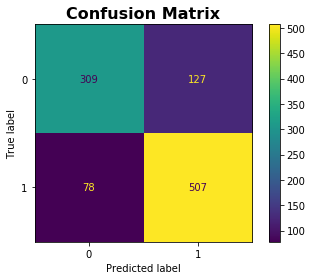

In [26]:
confusion_matrix_(y_test_ngram, y_pred_ngram_bern)

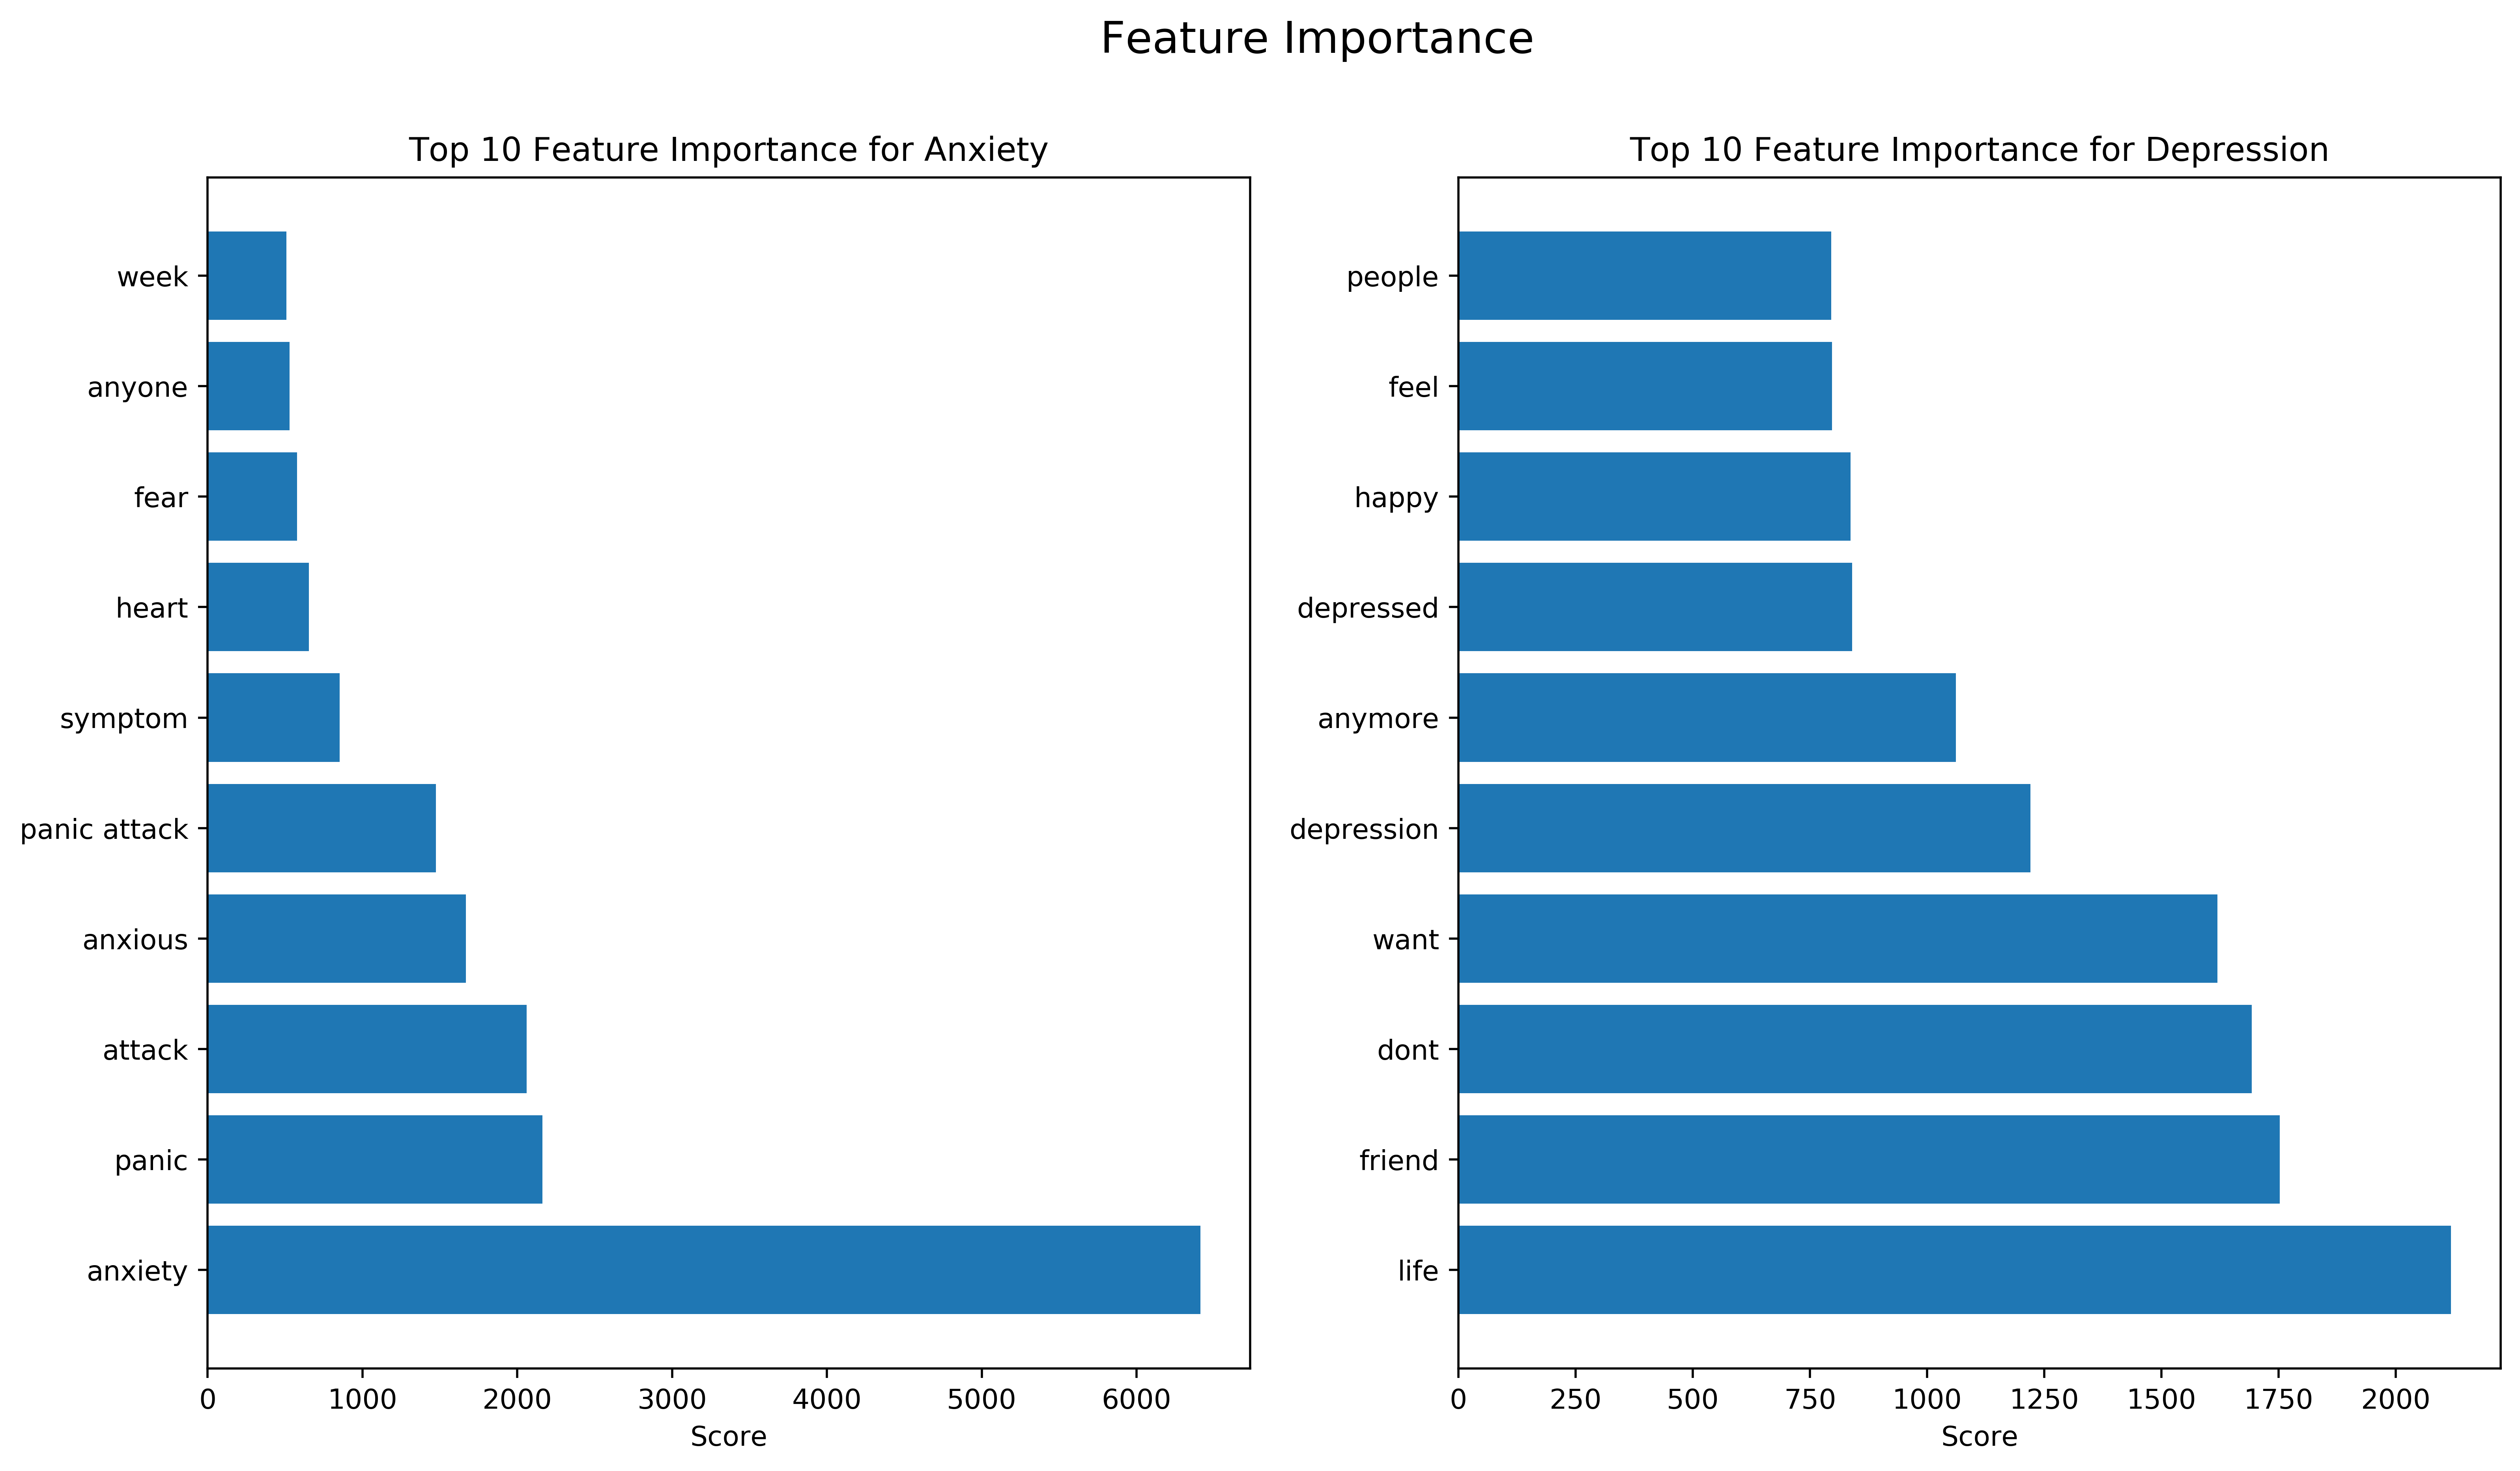

In [27]:
feature_importance_NB_display(ngram_bern, X_ngram, ngram_vec)

### Multinomial Naive Bayes

In [28]:
# Set parameters for gridsearch

MultiNB = MultinomialNB()
params = {
    'alpha' : [1, 2, 3]
}
model = GridSearchCV(MultiNB, params, cv=5)

In [29]:
# Run GridSearchCV

model.fit(X_train_ngram, y_train_ngram)
model.best_params_, model.best_score_

({'alpha': 3}, 0.8552865577075384)

In [30]:
# Run model with best parameters

MultiNB = MultinomialNB(alpha=3)
ngram_multi = MultiNB.fit(X_train_ngram, y_train_ngram)
y_pred_ngram_multi = ngram_multi.predict(X_test_ngram)
train_test_classification(y_pred_ngram_multi, ngram_multi, X_train_ngram, X_test_ngram, y_train_ngram, y_test_ngram)

Train Score: 0.901077375122429
Test Score: 0.8579823702252694


Classification Report
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       436
           1       0.90      0.85      0.87       585

    accuracy                           0.86      1021
   macro avg       0.85      0.86      0.86      1021
weighted avg       0.86      0.86      0.86      1021



<Figure size 7500x4000 with 0 Axes>

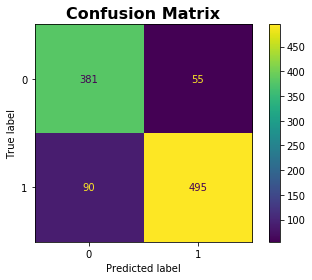

In [31]:
confusion_matrix_(y_test_ngram, y_pred_ngram_multi)

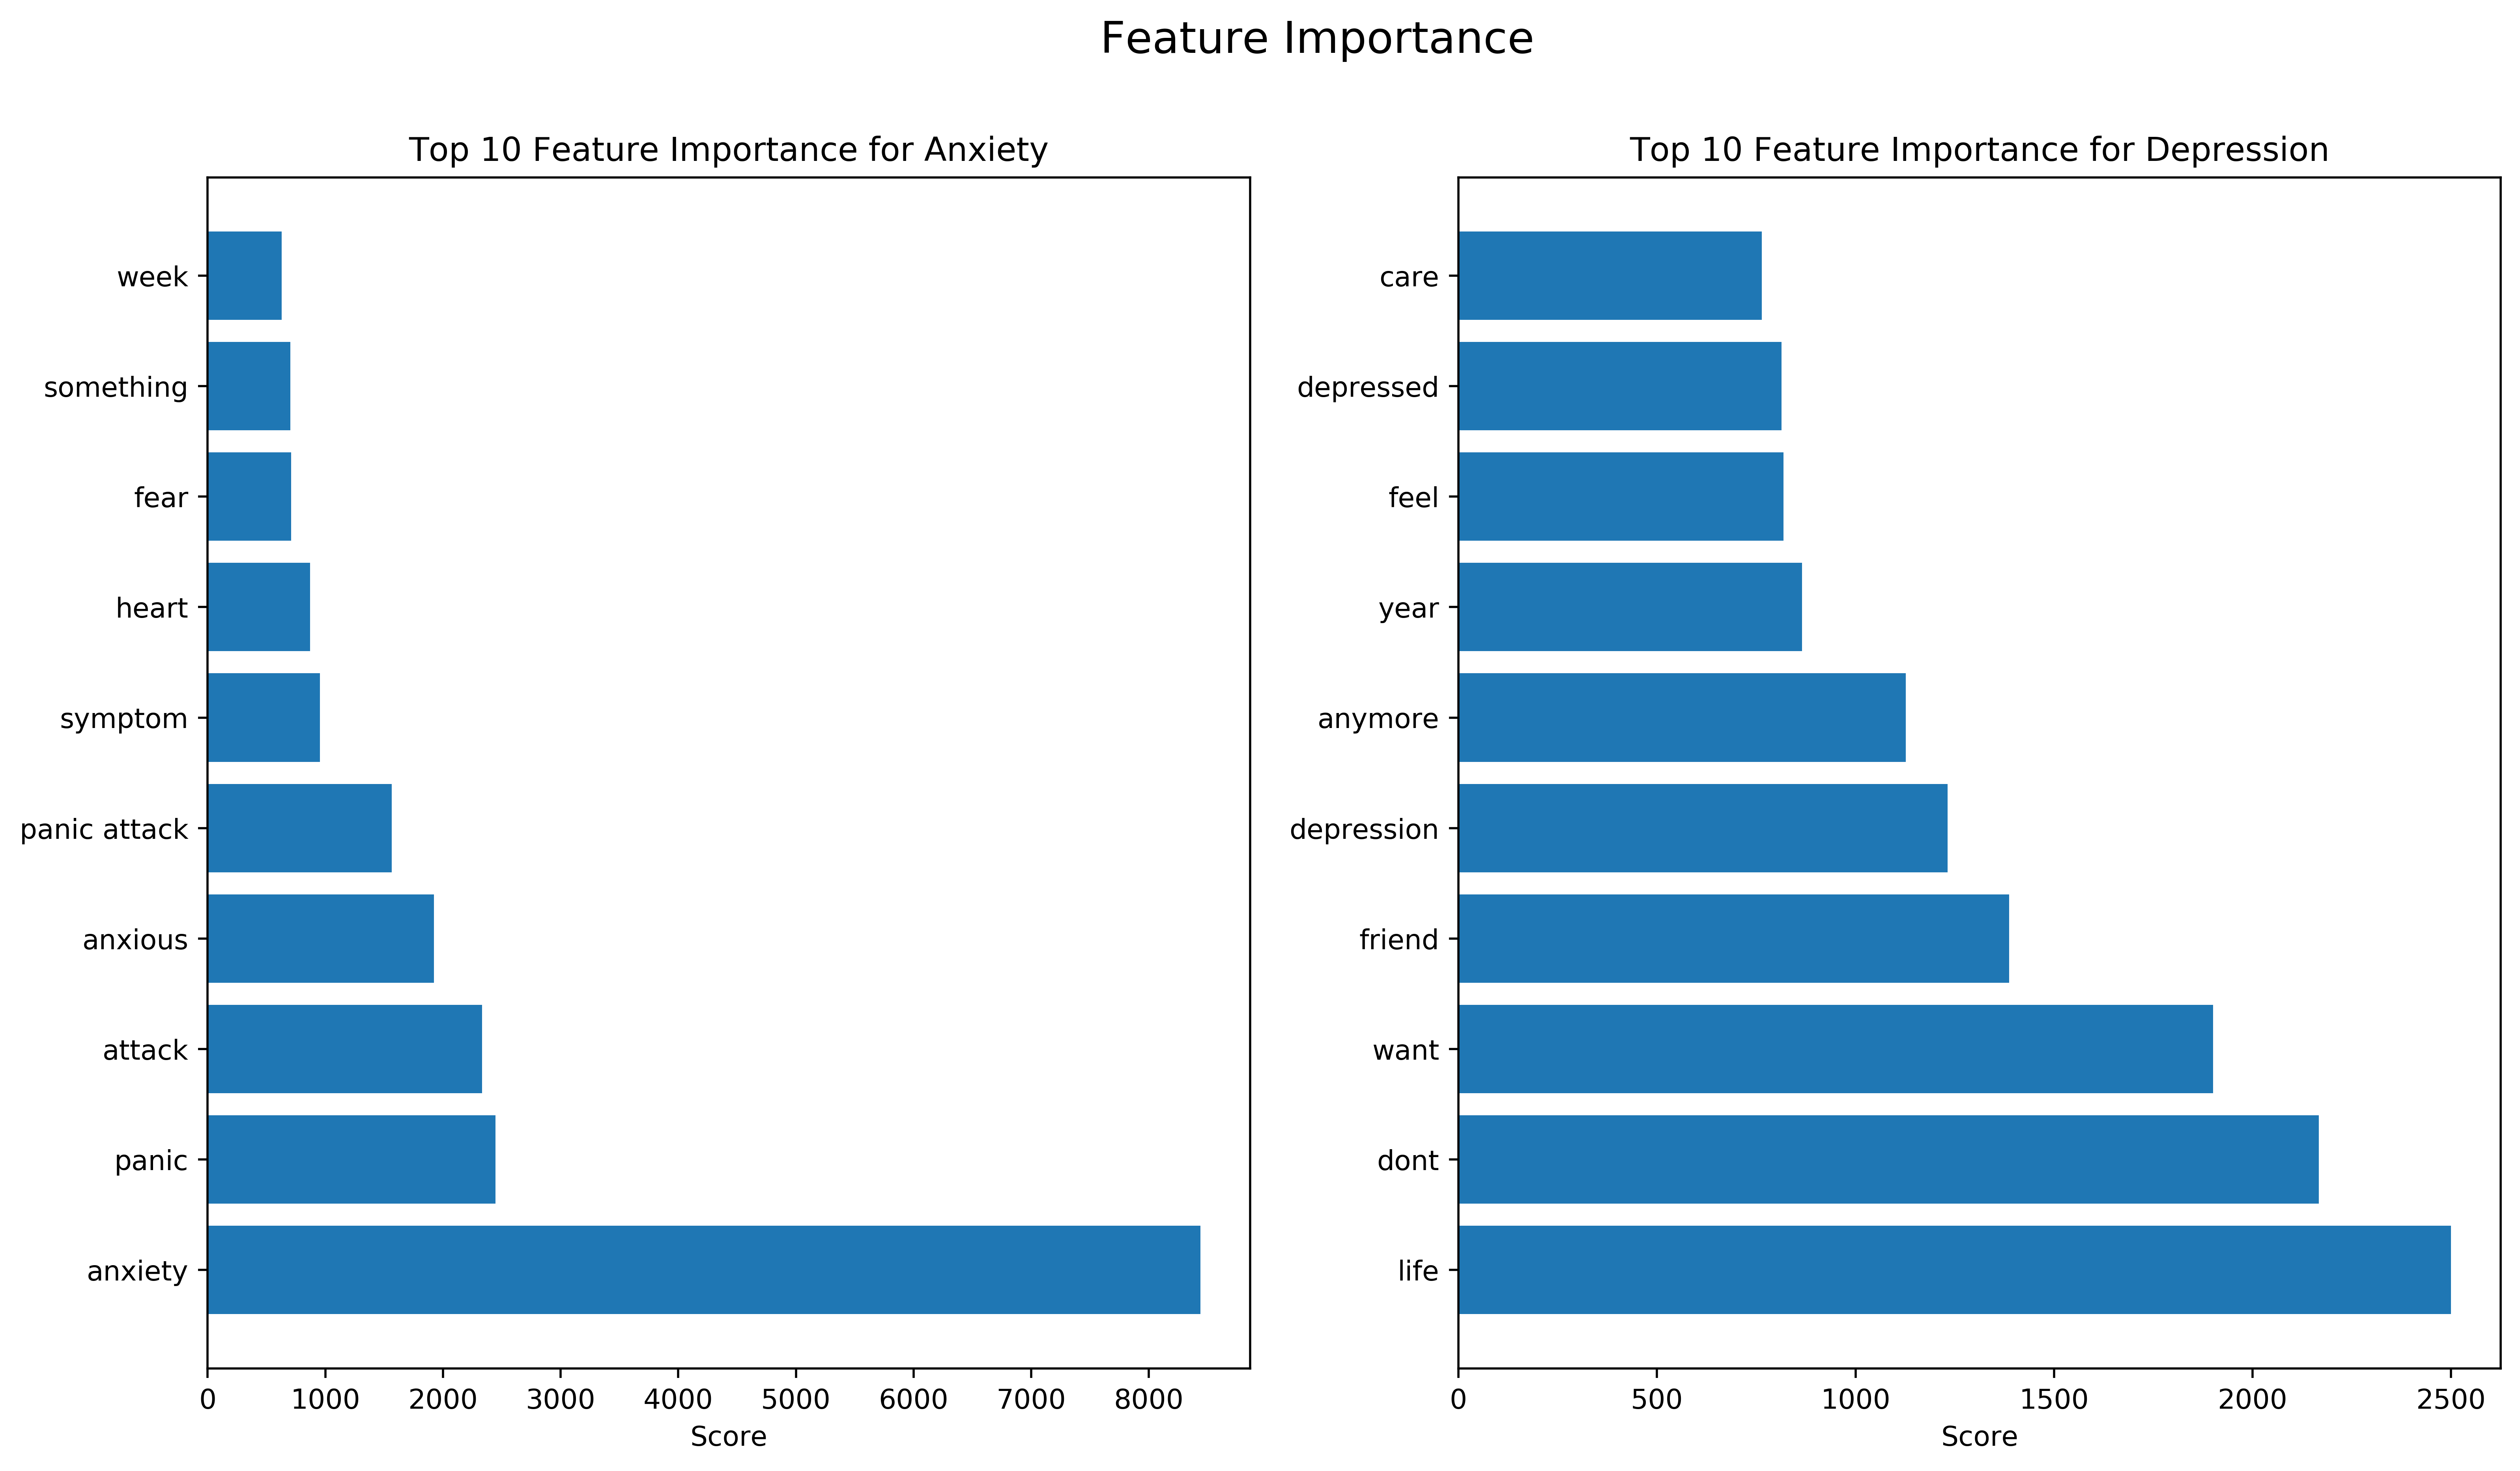

In [32]:
feature_importance_NB_display(ngram_multi, X_ngram, ngram_vec)

### Logistic Regression

In [33]:
lr = LogisticRegression(max_iter=1000)
ngram_lr = lr.fit(X_train_ngram, y_train_ngram)
y_pred_ngram_lr = ngram_lr.predict(X_test_ngram)
train_test_classification(y_pred_ngram_lr, ngram_lr, X_train_ngram, X_test_ngram, y_train_ngram, y_test_ngram)

Train Score: 0.9914299706170421
Test Score: 0.8658178256611165


Classification Report
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       436
           1       0.91      0.85      0.88       585

    accuracy                           0.87      1021
   macro avg       0.86      0.87      0.86      1021
weighted avg       0.87      0.87      0.87      1021



<Figure size 7500x4000 with 0 Axes>

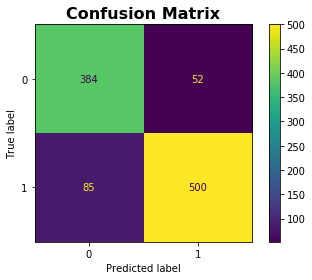

In [34]:
confusion_matrix_(y_test_ngram, y_pred_ngram_lr)

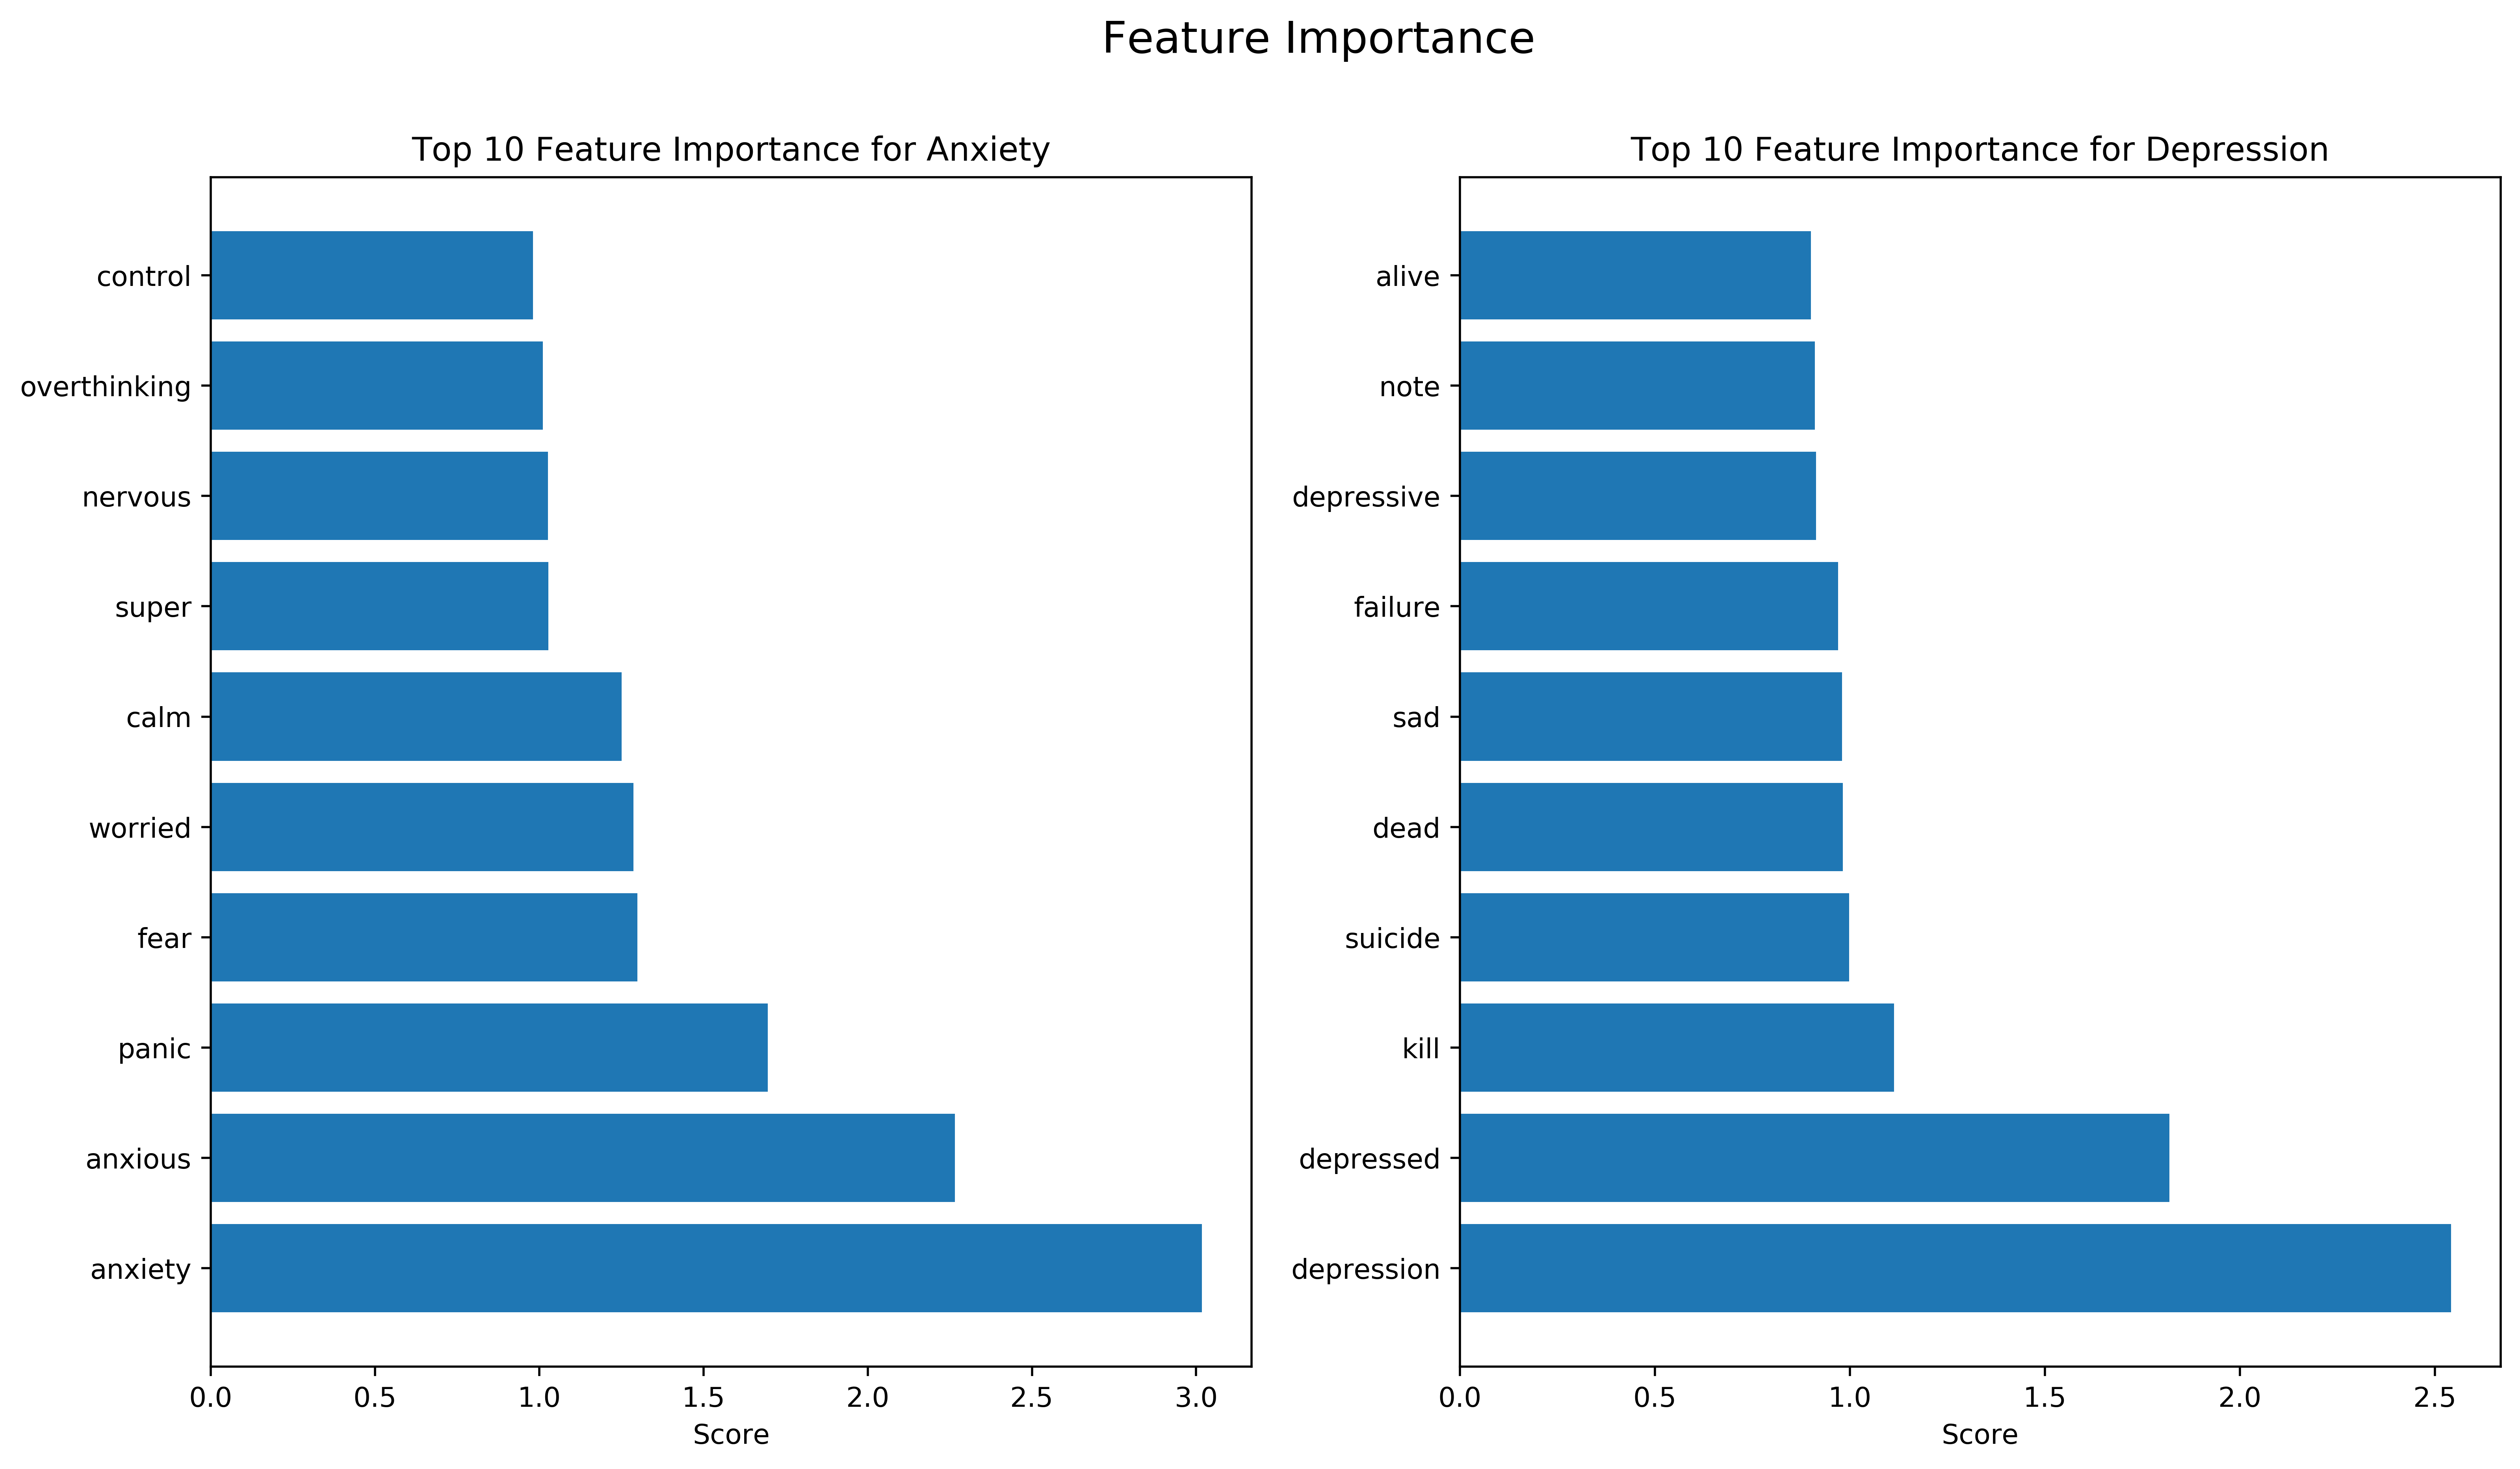

In [35]:
feature_importance_logistic(ngram_vec, ngram_lr)

## TF-IDF

In [36]:
# Create train and test datasets

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, train_size=0.8, random_state=1)

### Bernoulli Naive Bayes

In [37]:
BernNB = BernoulliNB()
tfidf_bern = BernNB.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf_bern = tfidf_bern.predict(X_test_tfidf)
train_test_classification(y_pred_tfidf_bern, tfidf_bern, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf)

Train Score: 0.8374142997061704
Test Score: 0.8001958863858962


Classification Report
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       436
           1       0.80      0.87      0.83       585

    accuracy                           0.80      1021
   macro avg       0.80      0.79      0.79      1021
weighted avg       0.80      0.80      0.80      1021



<Figure size 7500x4000 with 0 Axes>

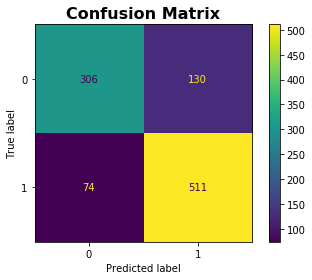

In [38]:
confusion_matrix_(y_test_tfidf, y_pred_tfidf_bern)

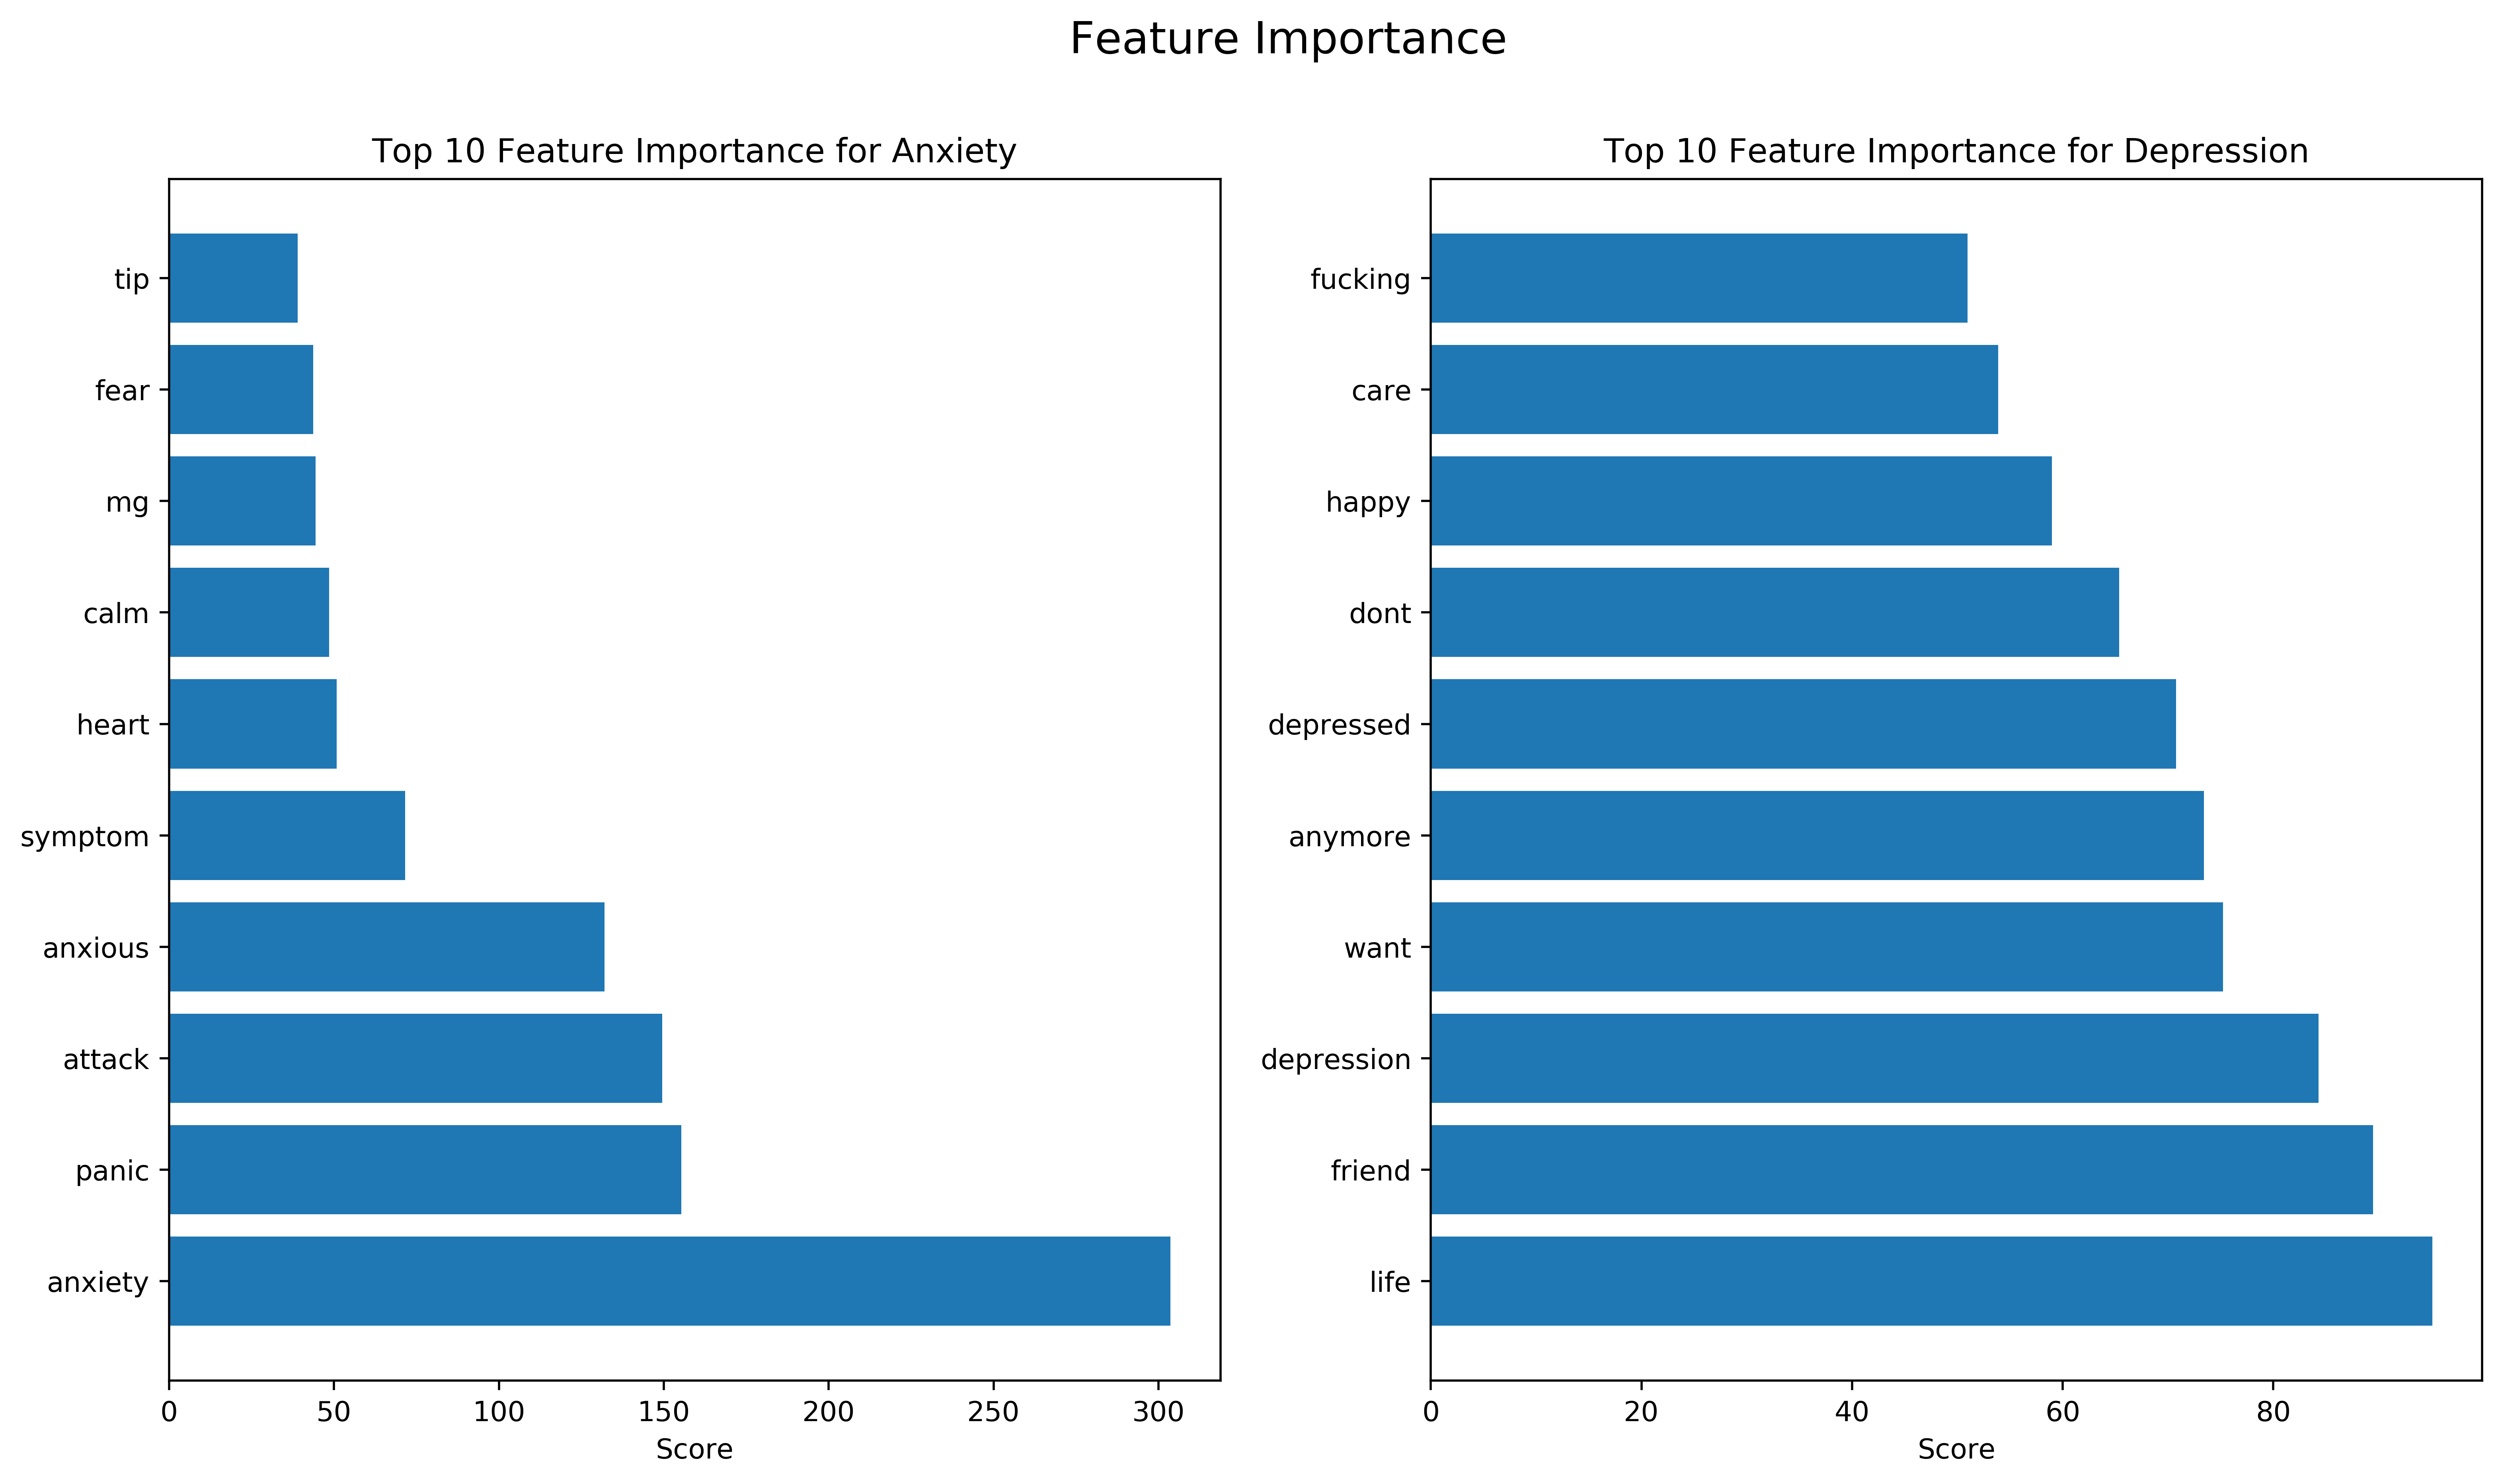

In [39]:
feature_importance_NB_display(tfidf_bern, X_tfidf, tfidf_vec)

### Multinomial Naive Bayes

In [40]:
# Set parameters for gridsearch

MultiNB = MultinomialNB()
params = {
    'alpha' : [1, 2, 3]
}
model = GridSearchCV(MultiNB, params, cv=5)

In [41]:
model.fit(X_train_tfidf, y_train_tfidf)
model.best_params_, model.best_score_

({'alpha': 1}, 0.8472085223318213)

In [42]:
# Run model with best parameters

MultiNB = MultinomialNB(alpha=1)
tfidf_multi = MultiNB.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf_multi = tfidf_multi.predict(X_test_tfidf)
train_test_classification(y_pred_tfidf_multi, tfidf_multi, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf)

Train Score: 0.9094025465230167
Test Score: 0.8589618021547503


Classification Report
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       436
           1       0.89      0.86      0.87       585

    accuracy                           0.86      1021
   macro avg       0.86      0.86      0.86      1021
weighted avg       0.86      0.86      0.86      1021



<Figure size 7500x4000 with 0 Axes>

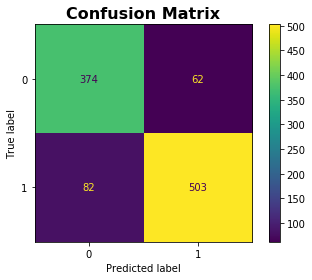

In [43]:
confusion_matrix_(y_test_tfidf, y_pred_tfidf_multi)

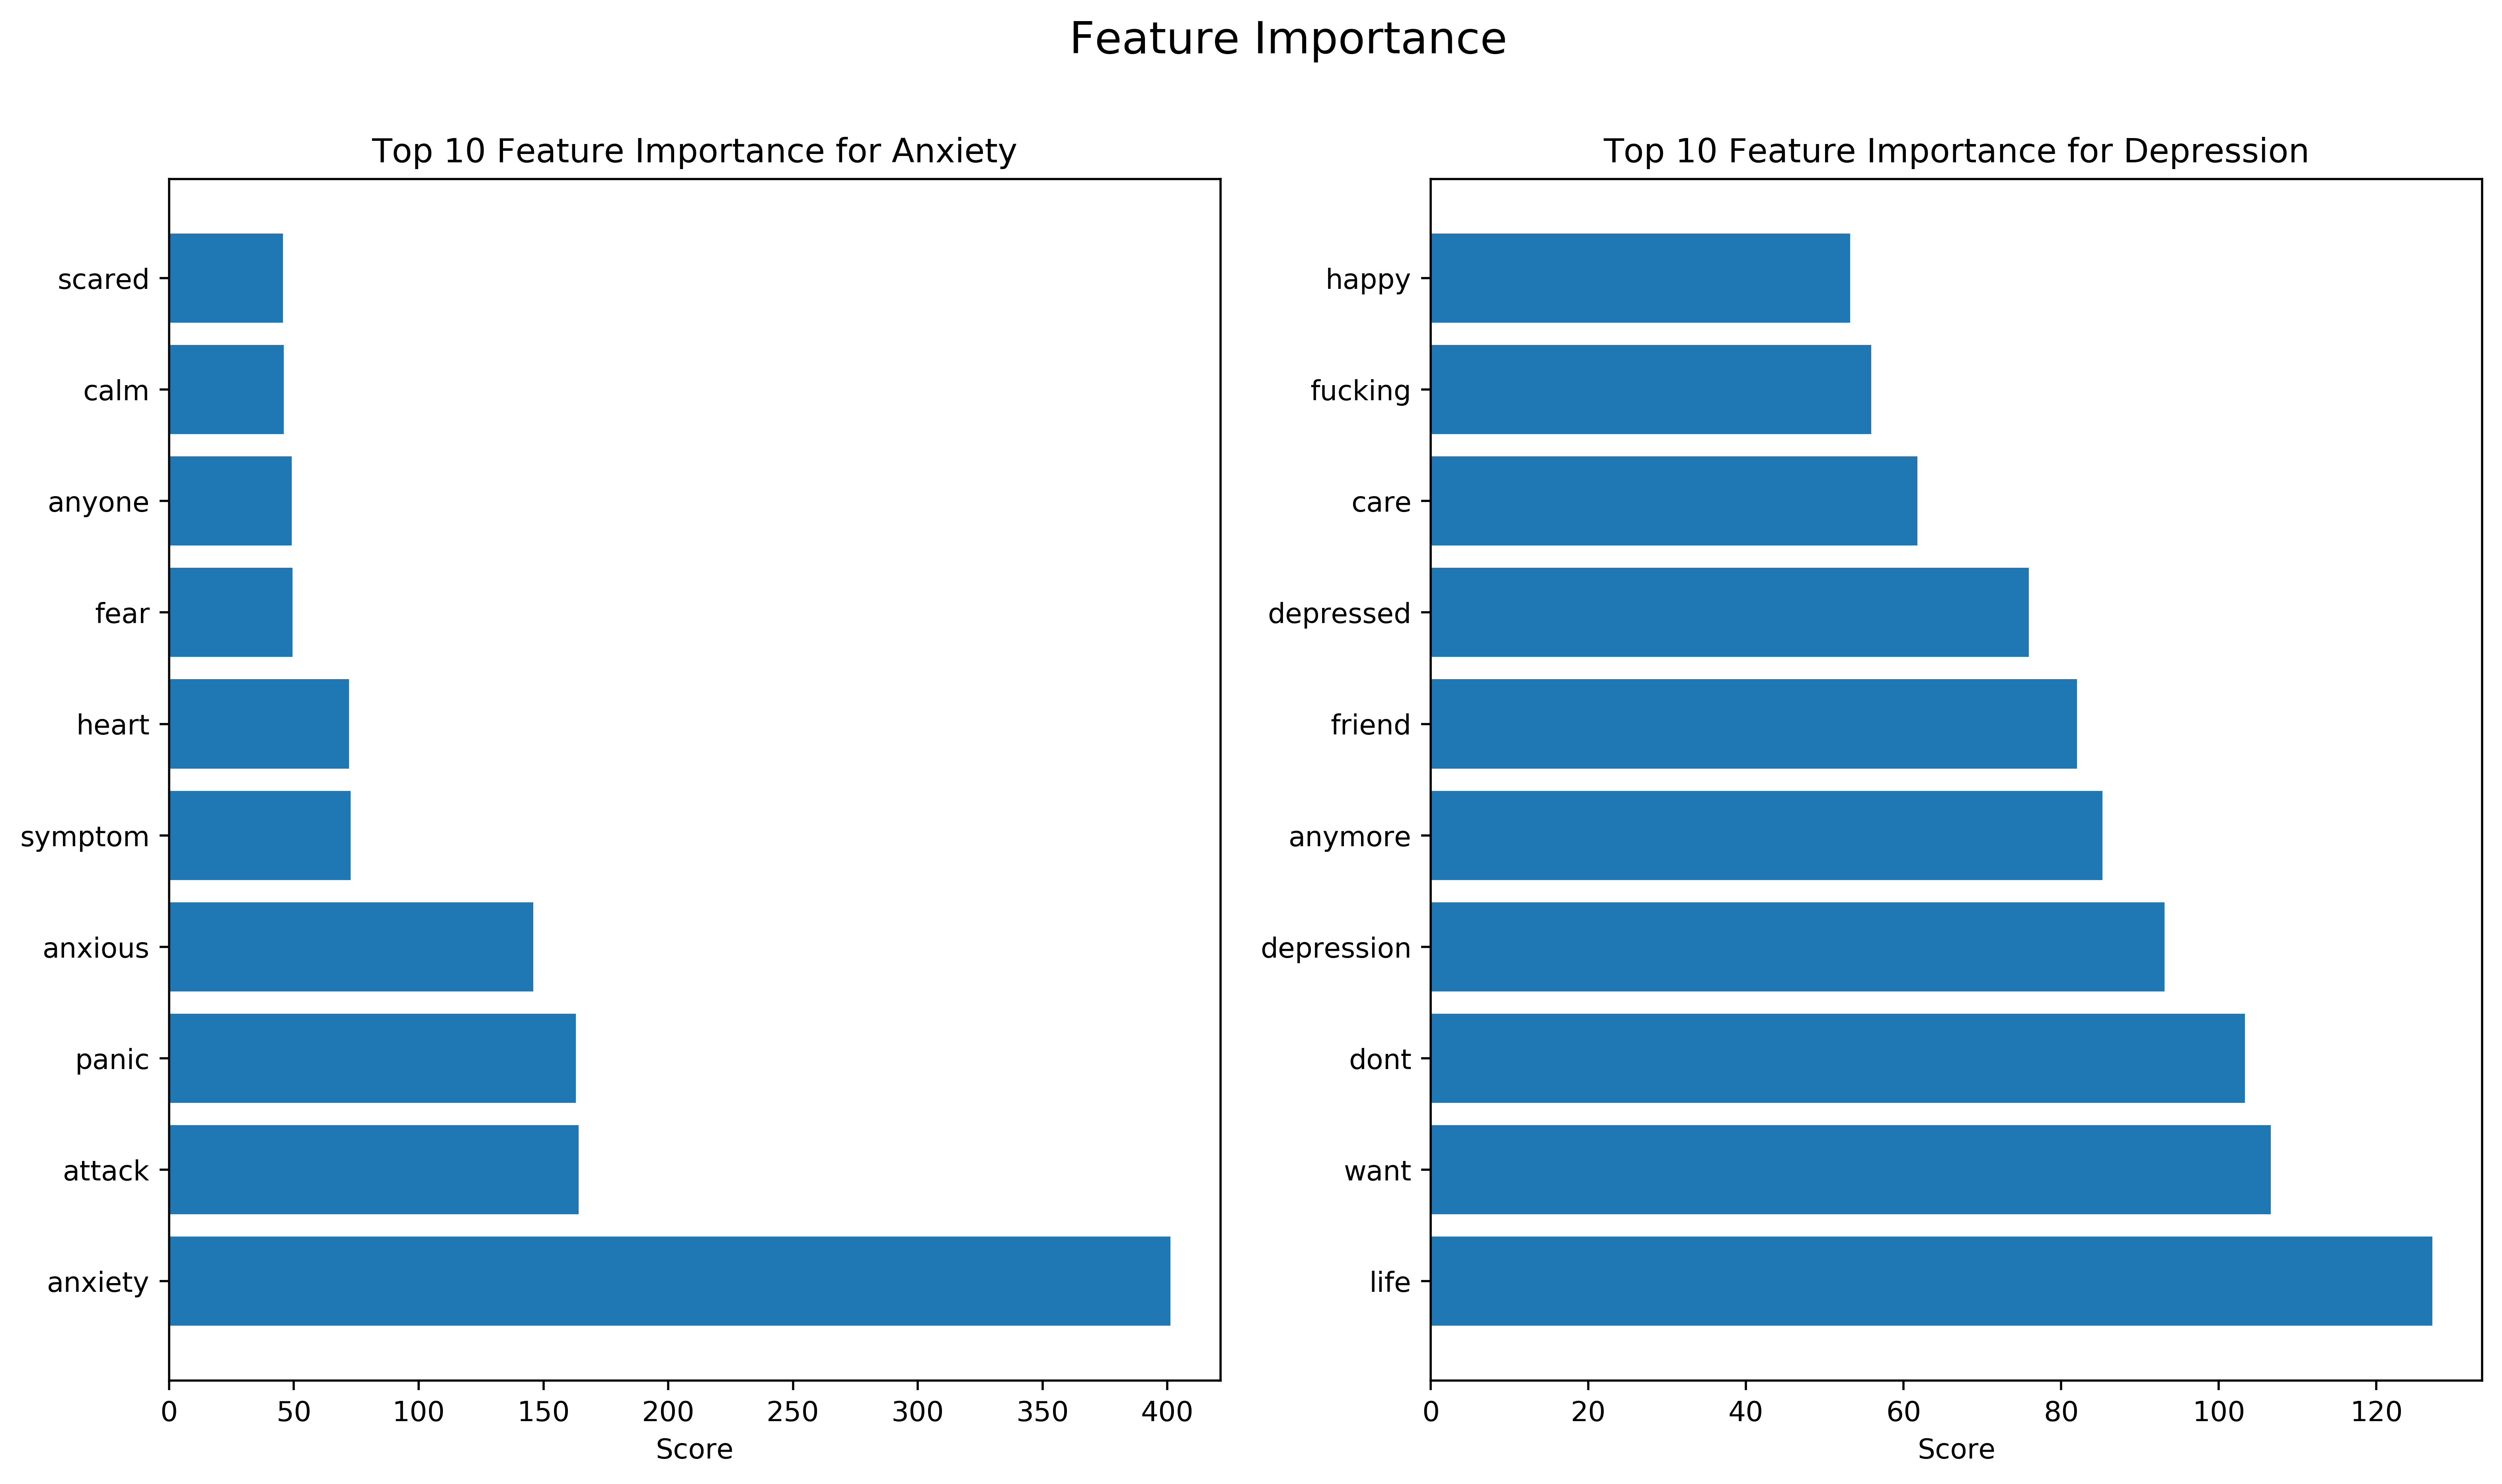

In [44]:
feature_importance_NB_display(tfidf_multi, X_tfidf, tfidf_vec)

### Logistic Regression

In [45]:
lr = LogisticRegression(max_iter=1000)
tfidf_lr = lr.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf_lr = tfidf_lr.predict(X_test_tfidf)
train_test_classification(y_pred_tfidf_lr, tfidf_lr, X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf)

Train Score: 0.9368266405484819
Test Score: 0.8628795298726738


Classification Report
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       436
           1       0.89      0.86      0.88       585

    accuracy                           0.86      1021
   macro avg       0.86      0.86      0.86      1021
weighted avg       0.86      0.86      0.86      1021



<Figure size 7500x4000 with 0 Axes>

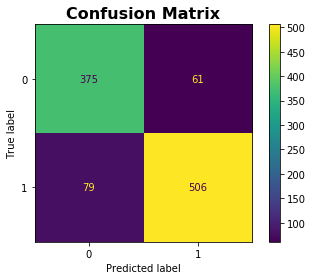

In [62]:
confusion_matrix_(y_test_tfidf, y_pred_tfidf_lr)

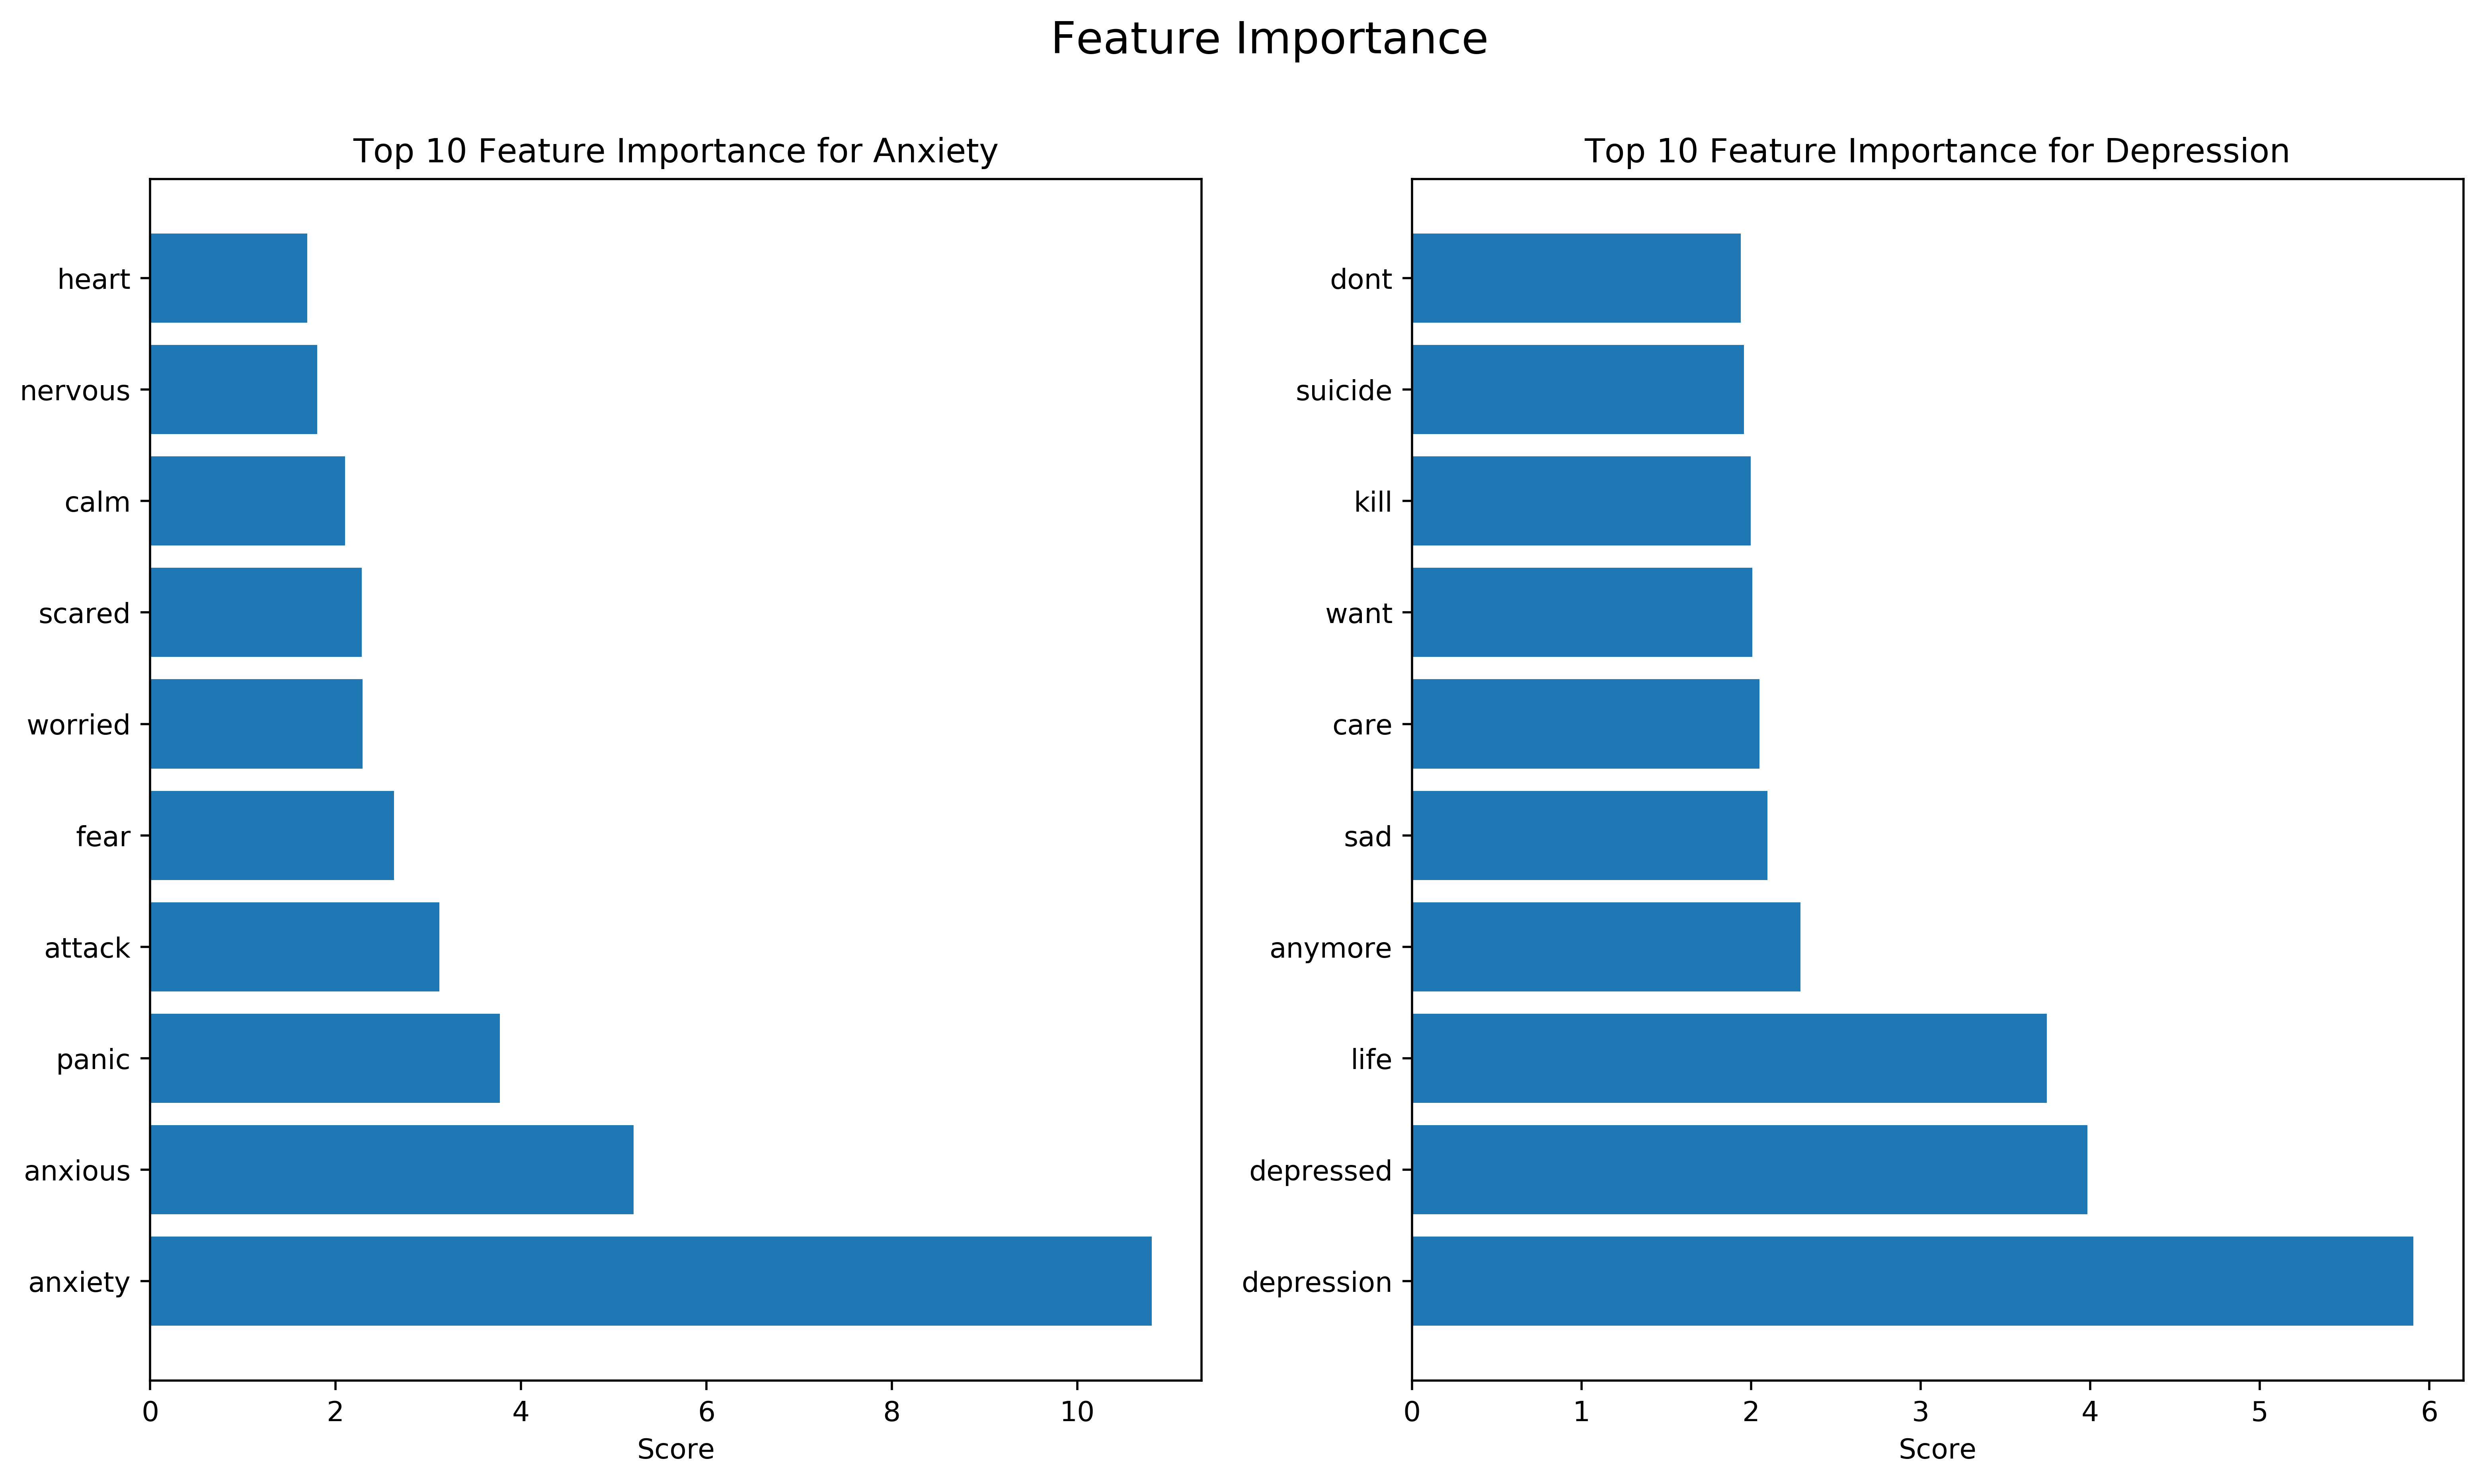

In [63]:
feature_importance_logistic(tfidf_vec, tfidf_lr)

#### AUC-ROC Curve

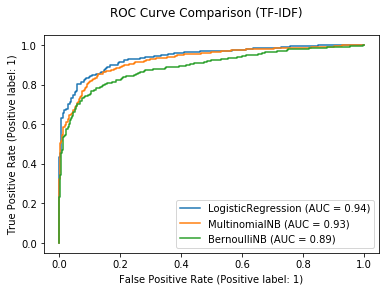

In [57]:
lr_disp = RocCurveDisplay.from_estimator(tfidf_lr, X_test_tfidf, y_test_tfidf)
mult_disp = RocCurveDisplay.from_estimator(tfidf_multi, X_test_tfidf, y_test_tfidf, ax=lr_disp.ax_)
bern_disp = RocCurveDisplay.from_estimator(tfidf_bern, X_test_tfidf, y_test_tfidf, ax=lr_disp.ax_)

lr_disp.figure_.suptitle("ROC Curve Comparison (TF-IDF)")

plt.savefig('ROC1.png', transparent=True)
plt.show()

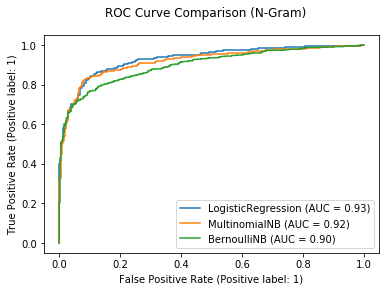

In [58]:
lr_disp = RocCurveDisplay.from_estimator(ngram_lr, X_test_ngram, y_test_ngram)
mult_disp = RocCurveDisplay.from_estimator(ngram_multi, X_test_ngram, y_test_ngram, ax=lr_disp.ax_)
bern_disp = RocCurveDisplay.from_estimator(ngram_bern, X_test_ngram, y_test_ngram, ax=lr_disp.ax_)

lr_disp.figure_.suptitle("ROC Curve Comparison (N-Gram)")

plt.savefig('ROC2.png', transparent=True)
plt.show()

# Summary

|Model|Method|Train Score|Accuracy|Precision (Depression)|Precision (Anxiety)|AUC|
|---|---|---|---|---|---|---|
|Logistic Regression|TF-IDF| 0.94|0.86|0.83|0.89|0.94|
|Multinomial Naive Bayes|TF-IDF|0.91|0.86|0.82|0.89|0.93|
|Bernoulli Naive Bayes|TF-IDF|0.84|0.80|0.81|0.80|0.89|
|Logistic Regression|N-Gram (1,2)|0.99|0.86|0.81|0.91|0.93|
|Multinomial Naive Bayes|N-Gram (1,2)|0.90|0.86|0.81|0.90|0.92|
|Bernoulli Naive Bayes|N-Gram (1,2)|0.85|0.80|0.79|0.80|0.90|

# Pickle Objects

In [51]:
import pickle

pickle.dump([tfidf_vec, tfidf_lr], open('nlp.pickle', 'wb'))